# 目的
遺伝子学的分類に基づいた、再発の2値分類を実施する。  

In [1]:
# 基本的なライブラリ
import os
from tqdm import tqdm

import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 50)

import matplotlib.pyplot as plt

%matplotlib inline

# パイプライン（imblearn）
from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler

# モデル
from sksurv.ensemble import (
    ComponentwiseGradientBoostingSurvivalAnalysis,
    GradientBoostingSurvivalAnalysis,
    RandomSurvivalForest,
    ExtraSurvivalTrees,
)
from sksurv.svm import FastKernelSurvivalSVM
from sksurv.linear_model import IPCRidge


# 評価指標
from sksurv.metrics import cumulative_dynamic_auc, concordance_index_ipcw

import config
import functions

SEED = config.SEED
TARGET_NAME = ["RFS_STATUS", "RFS_MONTHS"]
functions.fix_seed(SEED)


df_recurrenced = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_recurrenced4numeric.pkl"
)

/home/breast-cancer-analytics/notebooks/functions.py:196: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_train: pd.Series(),
/home/breast-cancer-analytics/notebooks/functions.py:198: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_val: pd.Series(),


# データ全体での予測モデル検証

## ベースモデルの学習結果

各特徴量選択されたdfを用いて基本的な2値分類モデルを学習する

In [2]:
def save_model_pipeline(
    pipeline: callable,
    val_step: str,
    save_file_path: str = ".",
):
    # fit後pipelineの保存
    pipeline_path = "{0}/{1}".format(save_file_path, val_step)
    functions.make_dir(pipeline_path)
    functions.pickle_dump(pipeline, "{0}/model_pipeline.pkl".format(pipeline_path))

In [3]:
def exists_pipeline(path: str) -> bool:
    return os.path.exists(path)

In [19]:
def plot_step_funcs(funcs, label=None, xlabel=None, ylabel=None):
    for fn in funcs:
        plt.step(fn.x, fn(fn.x), where="post", label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(0, 250)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()

In [84]:
def validate_model(
    model_order: dict = {"original_data": []},
    val_step="val_set",
    input_data_path: str = None,
    output_pipe_path: str = None,
    is_fitted: bool = False,
):
    try:
        _X_train = pd.read_pickle(
            "{0}/{1}/train/X.pkl".format(input_data_path, val_step)
        )
        _y_train = pd.read_pickle(
            "{0}/{1}/train/y.pkl".format(input_data_path, val_step)
        ).to_records(index=False)
        _X_test = pd.read_pickle("{0}/{1}/test/X.pkl".format(input_data_path, val_step))
        _y_test = pd.read_pickle(
            "{0}/{1}/test/y.pkl".format(input_data_path, val_step)
        ).to_records(index=False)
    except:
        print("data pkl file dose not exist")
        return pd.DataFrame()

    # display(_X_train.shape, _y_train.shape)
    # display(_X_test.shape, _y_test.shape)

    pipeline_path = "{0}/{1}".format(output_pipe_path, val_step)
    if exists_pipeline(pipeline_path) and is_fitted:
        # 学習済みパイプラインの使用
        _model_pipeline = functions.pickle_load(
            "{0}/model_pipeline.pkl".format(pipeline_path)
        )
    else:
        # パイプラインの学習の実施
        _model_pipeline = Pipeline(steps=model_order)
        _model_pipeline.fit(_X_train, _y_train)
    _estimator = _model_pipeline[-1]

    # c-indexスコアの表示
    _train_score = _estimator.score(_X_train, _y_train)
    _test_score = _estimator.score(_X_test, _y_test)

    # 累積AUCの表示
    _risk_test = _model_pipeline.predict(_X_test)
    va_times = np.arange(
        pd.DataFrame(_y_test).RFS_MONTHS.min(),
        pd.DataFrame(_y_test).RFS_MONTHS.max(),
        1,
    )
    cph_auc, cph_mean_auc = cumulative_dynamic_auc(
        _y_train, _y_test, _risk_test, va_times
    )
    plt.subplot(1, 3, 1)
    plt.plot(va_times, cph_auc, label=_estimator.__class__.__name__)
    plt.xlabel("months from surgery")
    plt.ylabel("time-dependent AUC")
    plt.xlim(0, 250)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()

    # plot survival funcs
    _surv_funcs_test = _model_pipeline.predict_survival_function(_X_test.iloc[:1])
    plt.subplot(1, 3, 2)
    plot_step_funcs(
        funcs=_surv_funcs_test,
        label=_estimator.__class__.__name__,
        xlabel="months from surgery",
        ylabel="surv rate",
    )

    # テストデータ患者のハザード率のプロット
    _chf_funcs_test = _estimator.predict_cumulative_hazard_function(_X_test.iloc[:1])
    plt.subplot(1, 3, 3)
    plot_step_funcs(
        funcs=_chf_funcs_test,
        label=_estimator.__class__.__name__,
        xlabel="months from surgery",
        ylabel="hazard rate",
    )

    df_score = pd.DataFrame(
        [_train_score, _test_score, cph_mean_auc],
        index=["train c-index", "test c-index", "AUC mean"],
        columns=[_estimator.__class__.__name__],
    ).round(3)

    if output_pipe_path:
        save_model_pipeline(
            pipeline=_model_pipeline,
            val_step=val_step,
            save_file_path=output_pipe_path,
        )
    return df_score

In [91]:
PCA_PERCENTILE = 95

# 実施したい学習の定義
model_order_dicts = [
    {
        "model_name": ComponentwiseGradientBoostingSurvivalAnalysis().__class__.__name__,
        "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
        "model_order": [
            (
                ComponentwiseGradientBoostingSurvivalAnalysis().__class__.__name__,
                ComponentwiseGradientBoostingSurvivalAnalysis(
                    n_estimators=1000,
                    random_state=config.SEED,
                ),
            ),
        ],
    },
    {
        "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
        "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
        "model_order": [
            (
                GradientBoostingSurvivalAnalysis().__class__.__name__,
                GradientBoostingSurvivalAnalysis(
                    n_estimators=1000,
                    random_state=config.SEED,
                ),
            ),
        ],
    },
    {
        "model_name": RandomSurvivalForest().__class__.__name__,
        "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
        "model_order": [
            (
                RandomSurvivalForest().__class__.__name__,
                RandomSurvivalForest(
                    n_estimators=1000,
                    min_samples_split=10,
                    min_samples_leaf=15,
                    n_jobs=-1,
                    random_state=config.SEED,
                ),
            ),
        ],
    },
    {
        "model_name": ExtraSurvivalTrees().__class__.__name__,
        "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
        "model_order": [
            (
                ExtraSurvivalTrees().__class__.__name__,
                ExtraSurvivalTrees(
                    random_state=config.SEED,
                    n_estimators=1000,
                    min_samples_split=10,
                    min_samples_leaf=15,
                    n_jobs=-1,
                ),
            ),
        ],
    },
]

In [ ]:
# 層別化する特徴量
subgroup_columns = [
    "CLAUDIN_SUBTYPE",
    # "THREEGENE",
]
# 遺伝子発現量以外の特徴量を削除
drop_columns = [
    "CLAUDIN_SUBTYPE",
    "THREEGENE",
]

val_step = "test_set"


for subgroup_column in subgroup_columns:  # 各サブグループへの適用
    for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループの要素毎への適用
        print("==========" * 10)
        print("subgroup: ", subgroup)
        # init each loop
        plt.figure(figsize=(18, 4))
        df_scores = pd.DataFrame(index=["train c-index", "test c-index", "AUC mean"])
        for model_order_dict in model_order_dicts:
            input_data_path = "./{0}/{1}/{2}/{3}".format(
                config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
                subgroup_column,
                subgroup,
                model_order_dict["preprocess_name"],
            )
            output_pipe_path = "./{0}/{1}/{2}/{3}/{4}".format(
                config.INTERIM_MODELS_RECURRENCE_DIR,
                subgroup_column,
                subgroup,
                model_order_dict["preprocess_name"],
                model_order_dict["model_name"],
            )
            df_score = validate_model(
                model_order=model_order_dict["model_order"],
                val_step=val_step,
                input_data_path=input_data_path,
                output_pipe_path=output_pipe_path,
                is_fitted=True,
            )
            df_scores = pd.merge(df_scores, df_score, right_index=True, left_index=True)
        display(pd.DataFrame(df_scores))
        output_fig_path = "./{0}/{1}/{2}/{3}".format(
            config.FIGURES_MODELS_RECURRENCE_DIR,
            subgroup_column,
            subgroup,
            model_order_dict["preprocess_name"],
        )
        functions.make_dir(output_fig_path)
        plt.title(subgroup)
        plt.savefig(output_fig_path + "/auc.png")
        plt.show()

subgroup:  claudin-low


In [43]:
data_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca80/test_set/test/X.pkl"
)

X = pd.read_pickle(data_path)

pipe_path = (
    config.INTERIM_MODELS_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca80/ComponentwiseGradientBoostingSurvivalAnalysis/test_set/model_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)

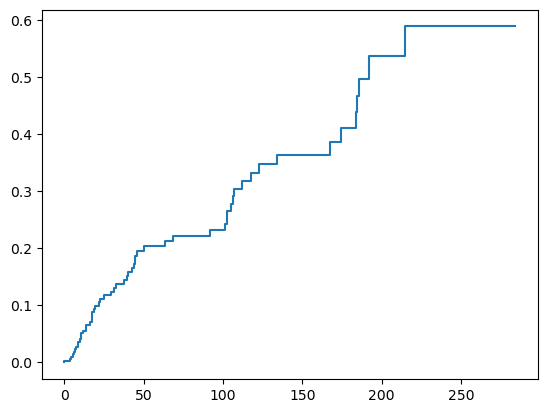

In [50]:
plt.step(
    pipe[-1].predict_cumulative_hazard_function(X)[1].x,
    pipe[-1].predict_cumulative_hazard_function(X)[1].y,
)